In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from peptdeep.pretrained_models import ModelManager

from alphabase.spectral_library.base import SpecLibBase
from alphadia import data, planning
from alphadia.workflow import manager, peptidecentric
from alphadia.tunning import settings, FinetuneManager


In [2]:
import torch
torch.set_num_threads(10)

In [2]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/second_pass_score/second_pass_score/output/speclib.transfer.hdf', load_mod_seq=True)

In [3]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/d0_search/output/speclib.transfer.hdf', load_mod_seq=True)

## RT Fine-tuning


2024-04-19 23:42:35> Predicting RT ...


100%|██████████| 29/29 [00:02<00:00, 11.23it/s]


Text(0, 0.5, 'RT predicted')

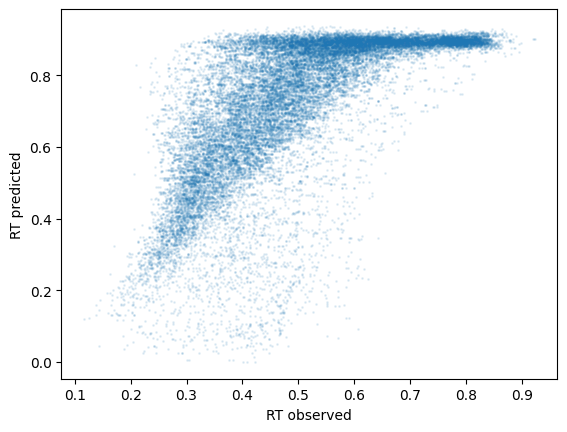

In [35]:

tune_mgr = FinetuneManager(
    device="mps",
    settings=settings)
tune_mgr.nce = 25
tune_mgr.instrument = 'Lumos'
transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)
plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')

2024-04-19 23:42:38> Fine-tuning RT model
2024-04-19 23:42:46> Epoch 0: Lr:0.001 Training loss: 0.07425634216131835, Test loss: 0.04541949300562134
2024-04-19 23:42:53> Epoch 1: Lr:0.0 Training loss: 0.04409998025873612, Test loss: 0.04541949300562134
2024-04-19 23:43:00> Epoch 2: Lr:0.0002 Training loss: 0.04014473331385646, Test loss: 0.0378322712260012
2024-04-19 23:43:07> Epoch 3: Lr:0.0004 Training loss: 0.03505932838366977, Test loss: 0.03366744996273025
2024-04-19 23:43:14> Epoch 4: Lr:0.0006000000000000001 Training loss: 0.03126626012140307, Test loss: 0.03181591026449207
2024-04-19 23:43:21> Epoch 5: Lr:0.0008 Training loss: 0.02940236555476641, Test loss: 0.030851618871752355
2024-04-19 23:43:28> Epoch 6: Lr:0.0008 Training loss: 0.027848890436620546, Test loss: 0.028262663356724987
2024-04-19 23:43:35> Epoch 7: Lr:0.0008 Training loss: 0.026028199249814296, Test loss: 0.027881791615992073
2024-04-19 23:43:42> Epoch 8: Lr:0.0008 Training loss: 0.023490573504361612, Test loss:

100%|██████████| 29/29 [00:02<00:00, 11.33it/s]


Text(0, 0.5, 'RT predicted')

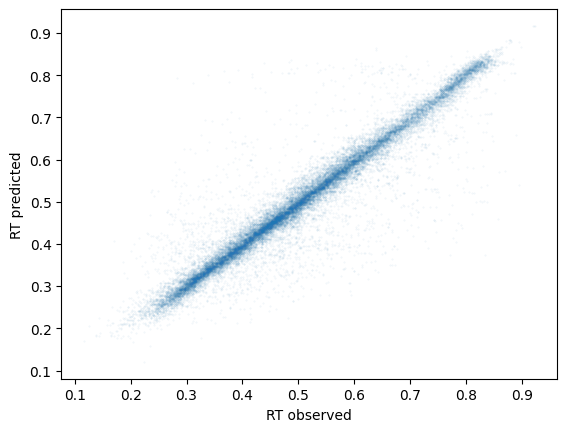

In [36]:
stats = tune_mgr.finetune_rt(transfer_lib.precursor_df)

transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)

plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=0.1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')


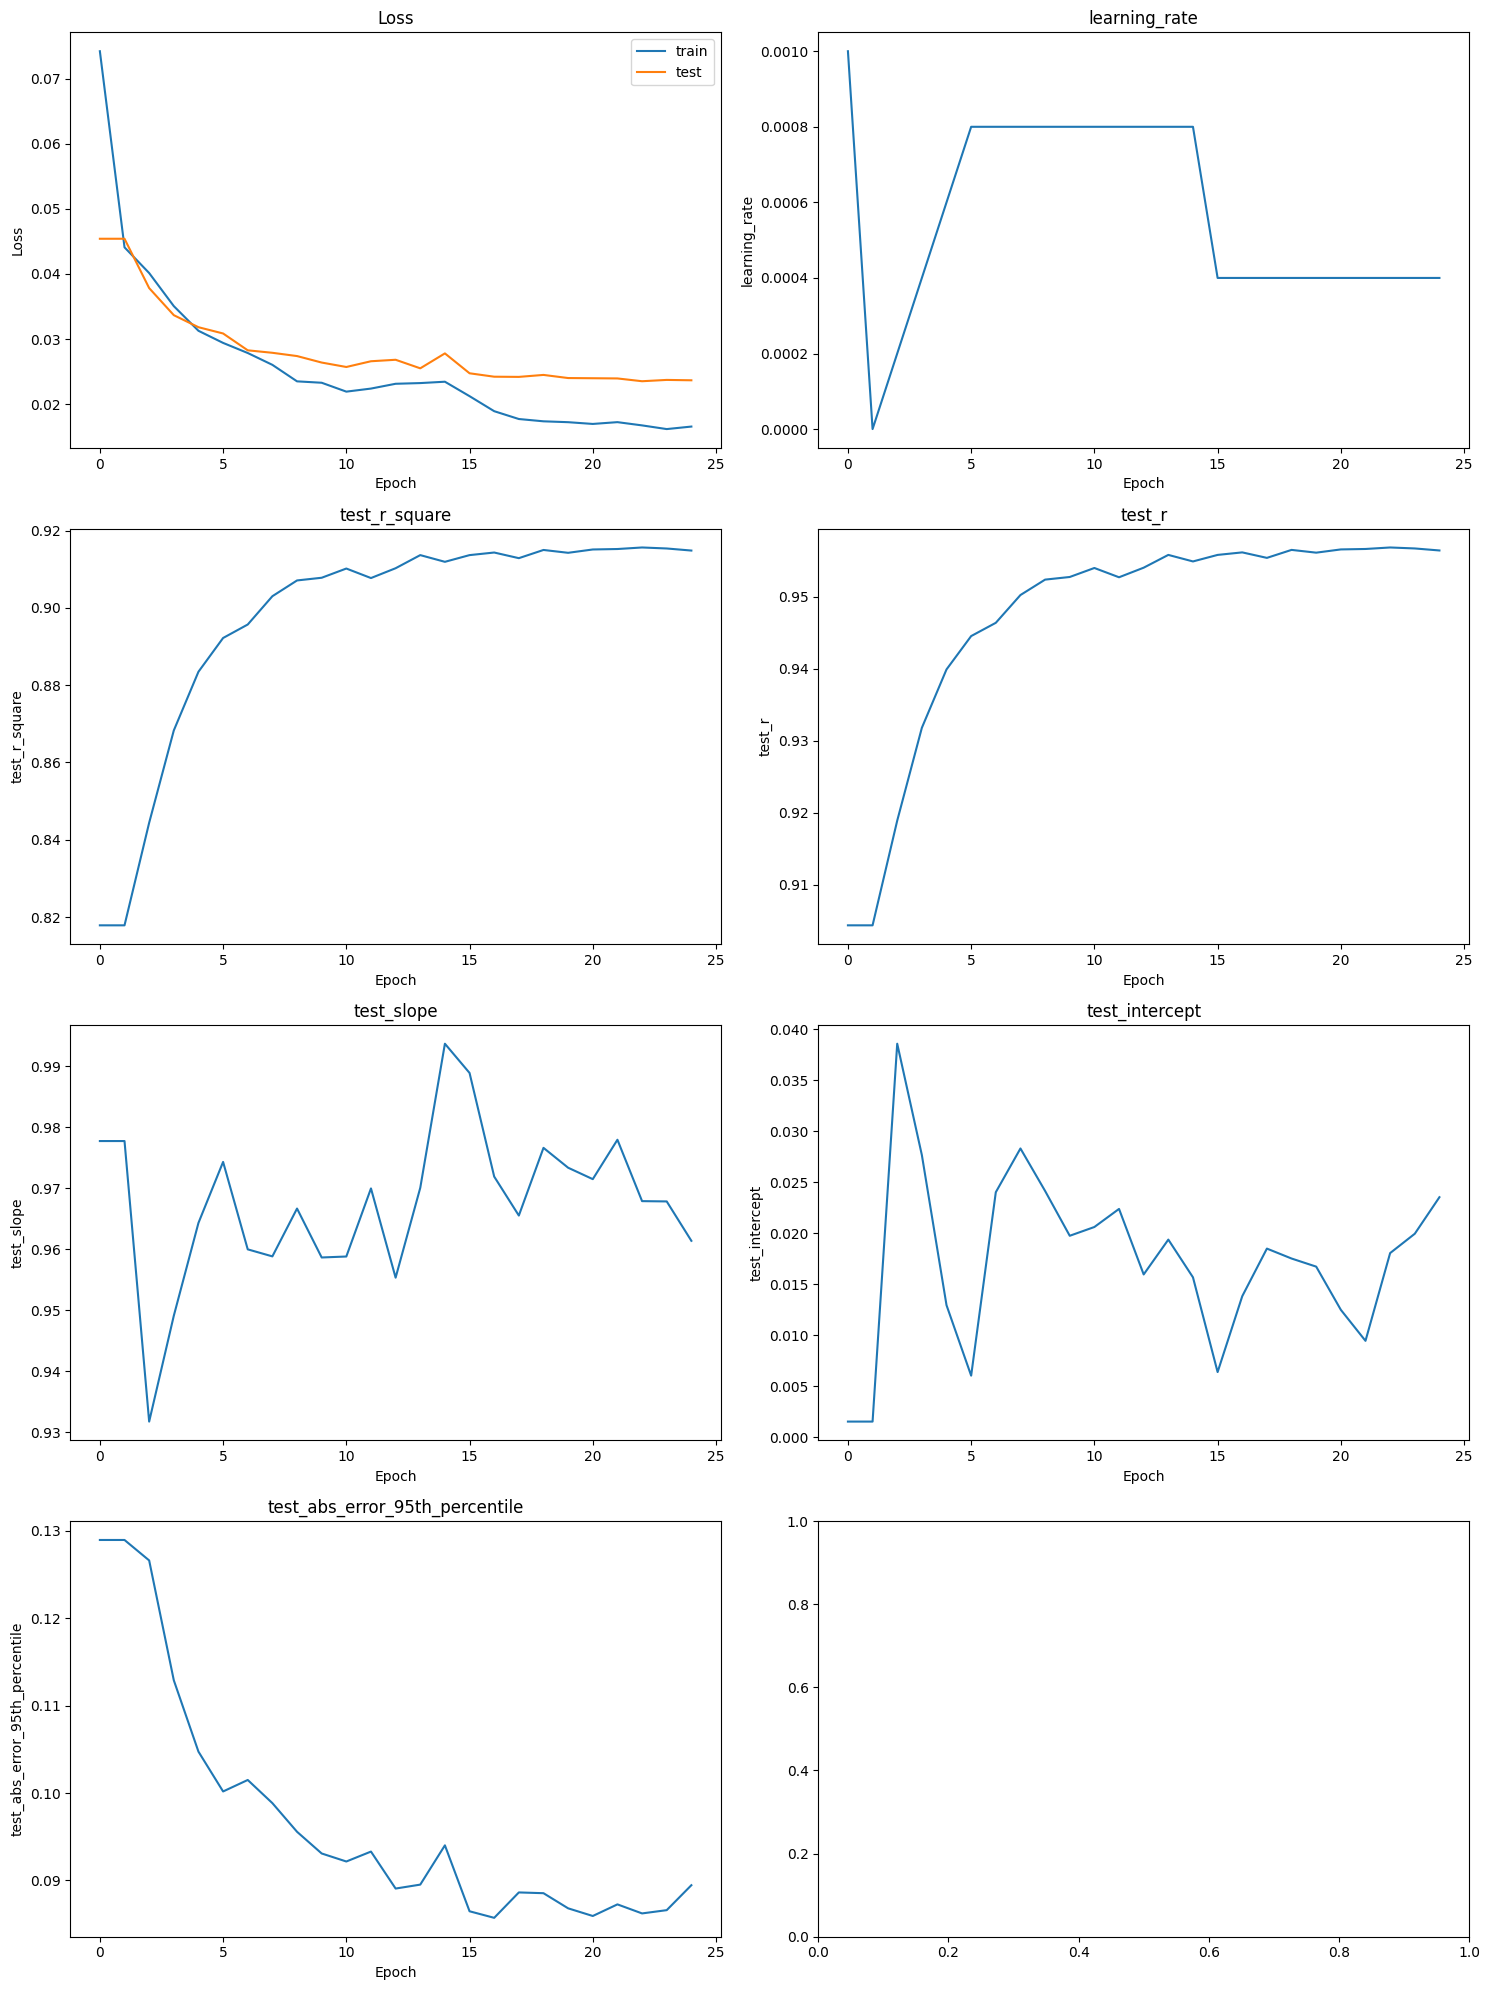

In [37]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()


# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()

## Charge Fine-tuning

In [25]:

# Testing the charge finetuning on the transfer library
stats = tune_mgr.finetune_charge(psm_df=transfer_lib.precursor_df)

2024-04-19 23:06:06> Fine-tuning Charge model
2024-04-19 23:06:18> Epoch 0: Lr:0.001 Training loss: 0.3666207944353422, Test loss: 0.3359060051104337
2024-04-19 23:06:29> Epoch 1: Lr:0.0 Training loss: 0.3483478461702665, Test loss: 0.3359060051104337
2024-04-19 23:06:40> Epoch 2: Lr:0.0002 Training loss: 0.2620933356384436, Test loss: 0.3394559445969991
2024-04-19 23:06:52> Epoch 3: Lr:0.0004 Training loss: 0.24424849847952526, Test loss: 0.3248667953267428
2024-04-19 23:07:03> Epoch 4: Lr:0.0006000000000000001 Training loss: 0.22509374196330706, Test loss: 0.32281981826248846
2024-04-19 23:07:14> Epoch 5: Lr:0.0008 Training loss: 0.22561403165260951, Test loss: 0.4103117340453373
2024-04-19 23:07:25> Epoch 6: Lr:0.0008 Training loss: 0.23411569992701212, Test loss: 0.307858747423216
2024-04-19 23:07:36> Epoch 7: Lr:0.0008 Training loss: 0.27481507683793704, Test loss: 0.32261299914989033
2024-04-19 23:07:47> Epoch 8: Lr:0.0008 Training loss: 0.24783622038861117, Test loss: 0.36178081

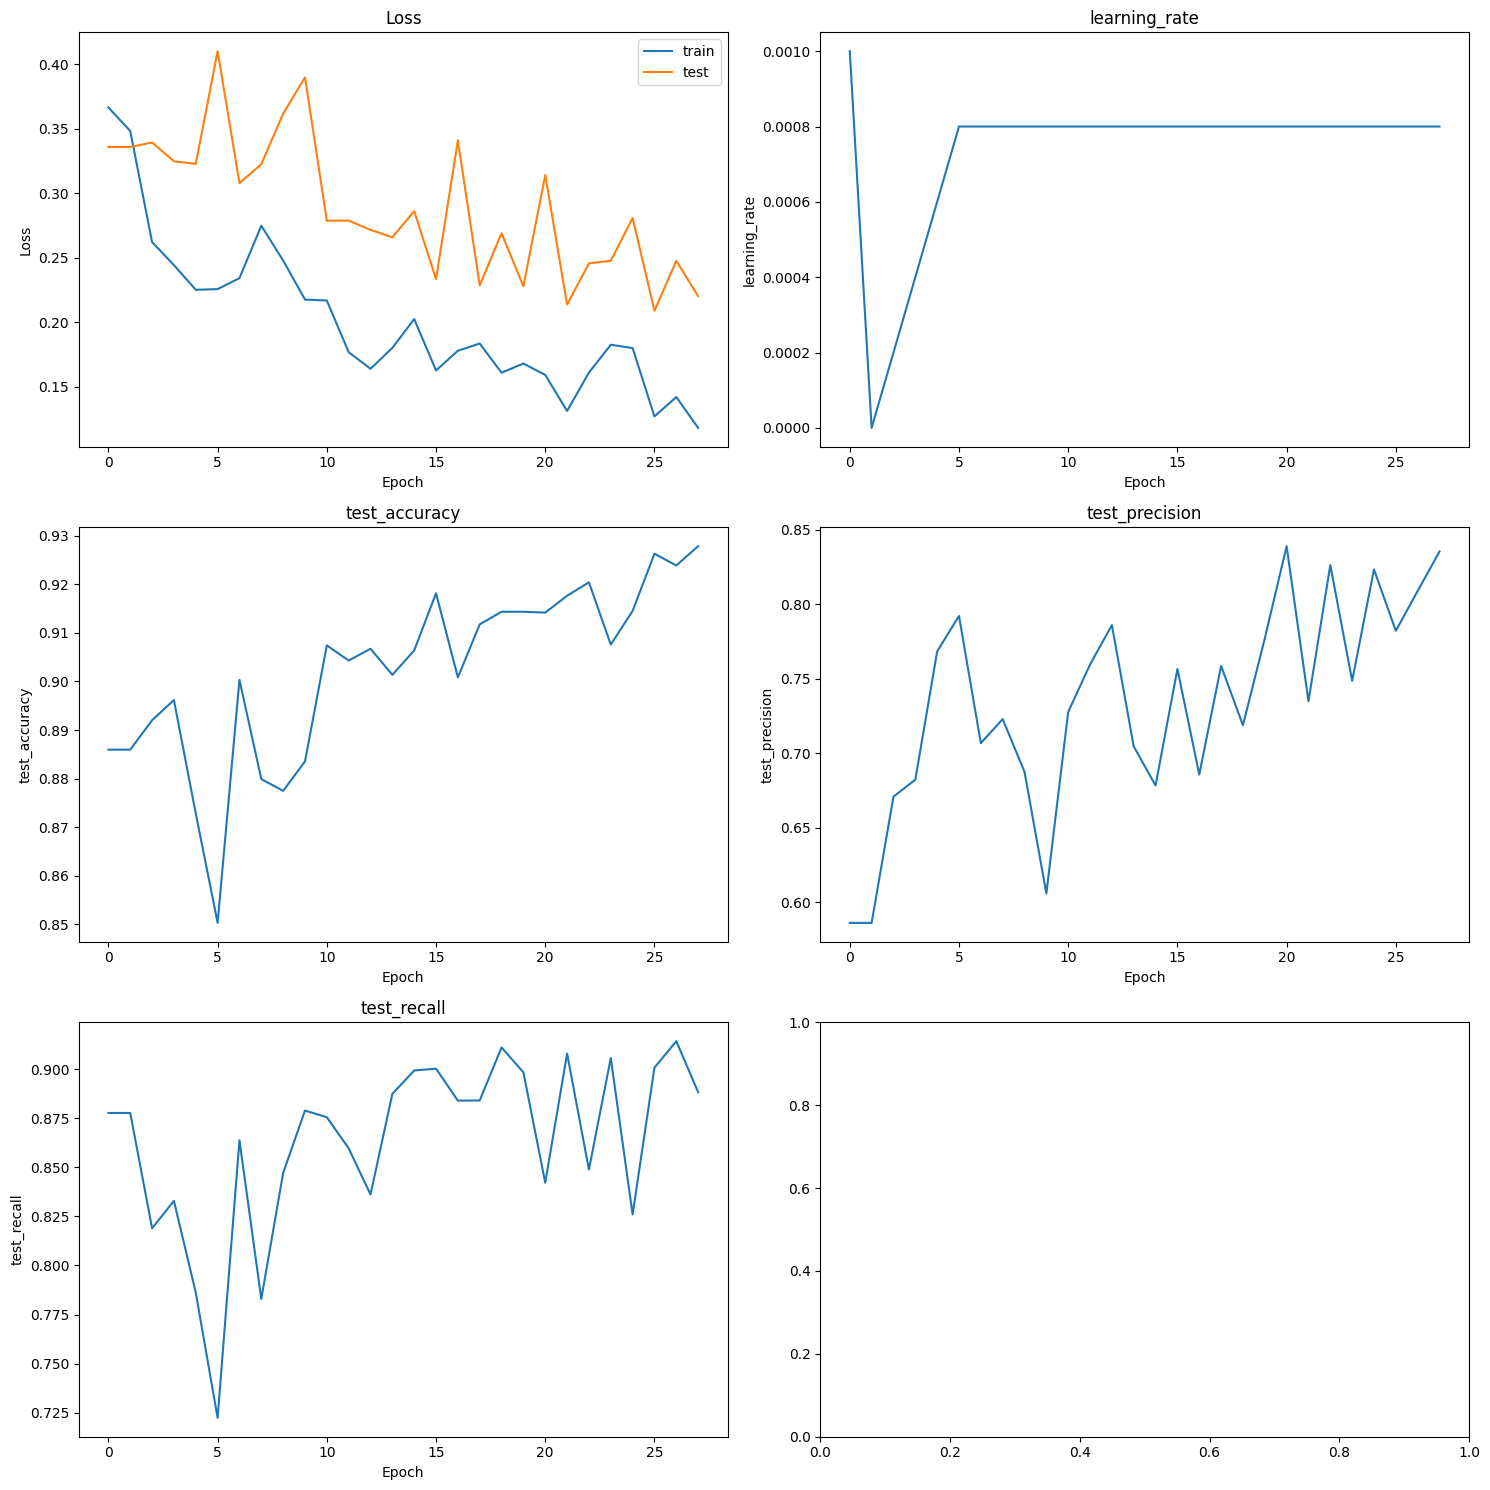

In [27]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()

## MS2 Fine-tuning

In [31]:

# Testing the ms2 finetuning on the transfer library
stats = tune_mgr.finetune_ms2(psm_df=transfer_lib.precursor_df,matched_intensity_df=transfer_lib.fragment_intensity_df)

2024-04-19 23:37:03> Fine-tuning MS2 model
2024-04-19 23:37:35> Epoch 0: Lr:0.001 Training loss: 0.017610015122797983, Test loss: 105.32062023997713
2024-04-19 23:38:05> Epoch 1: Lr:0.0 Training loss: 0.01582635704684874, Test loss: 105.32062023997713
2024-04-19 23:38:34> Epoch 2: Lr:0.0002 Training loss: 0.015057623097351912, Test loss: 105.32106991047291
2024-04-19 23:39:04> Epoch 3: Lr:0.0004 Training loss: 0.013058155341523475, Test loss: 105.32062204157569
2024-04-19 23:39:33> Epoch 4: Lr:0.0006000000000000001 Training loss: 0.012706901653316515, Test loss: 105.32025263618122
2024-04-19 23:40:03> Epoch 5: Lr:0.0008 Training loss: 0.012793854184063345, Test loss: 105.31916430808276
2024-04-19 23:40:33> Epoch 6: Lr:0.0008 Training loss: 0.012641142427535921, Test loss: 105.32069829513242
Training stopped at epoch 6
2024-04-19 23:40:33> Fine tuning finished at epoch: 6 
train_loss: 0.012641142427535921 
learning_rate: 0.0008 
test_loss: 105.32069829513242 
test_pcc_mean: 0.0683985278

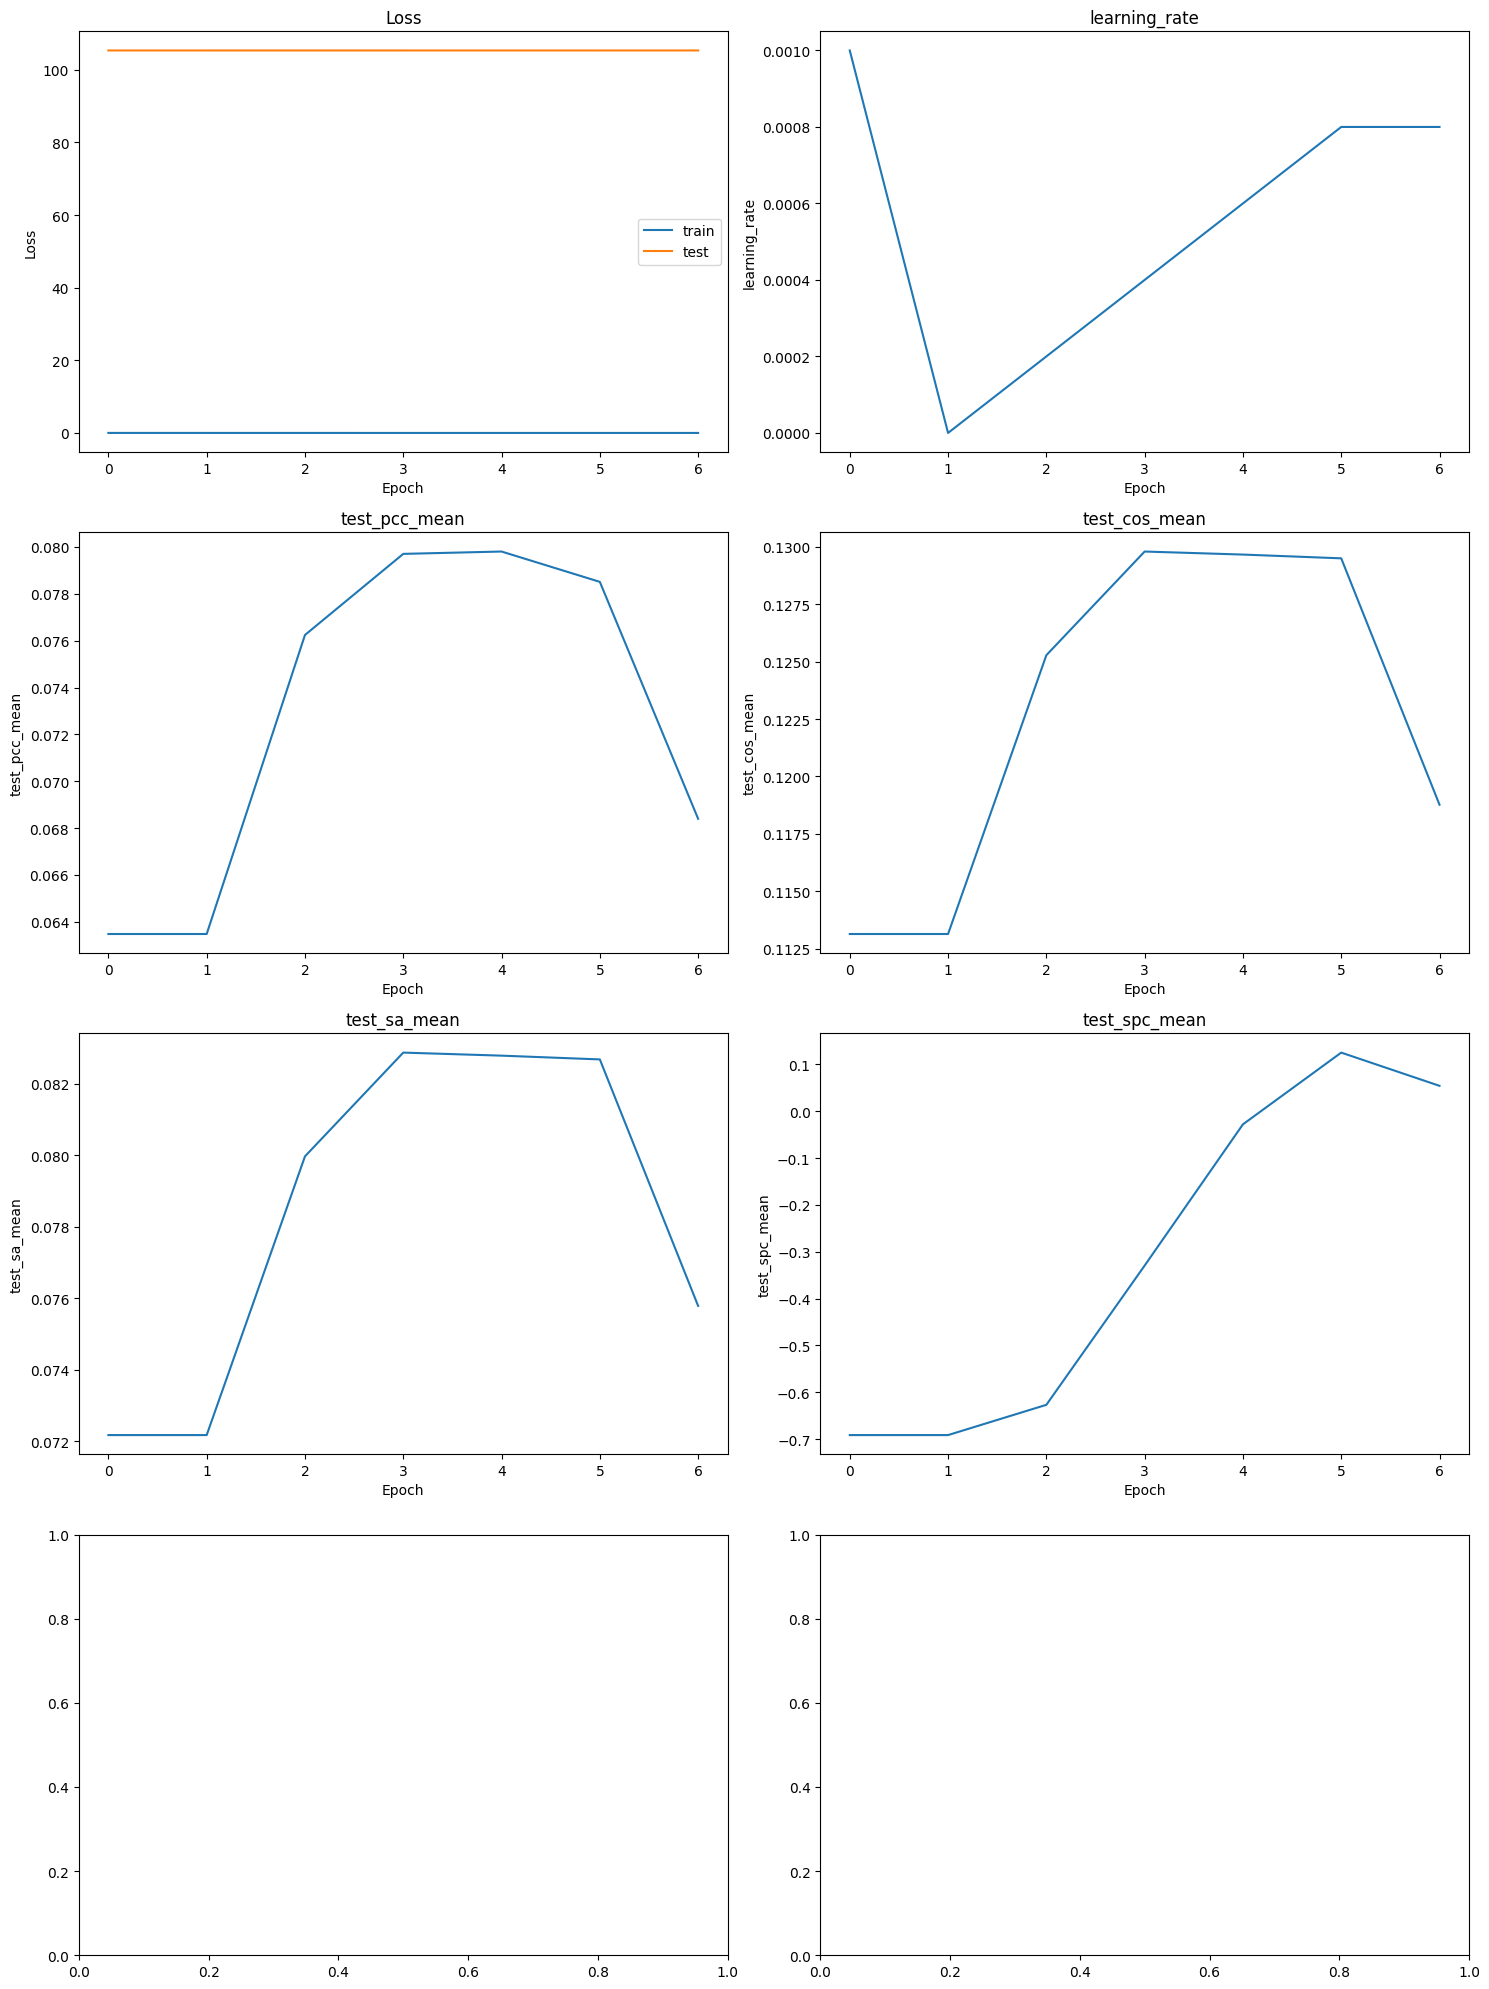

In [32]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()


# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()